# Predicting Dementia Severity using Modifiable Risk Factors

Ananya Jaishankar, Frances McKnight, Luz Pascual

## Setup

We begin by loading in all necessary packages, reading in the data, and defining helper functions.

In [30]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
# !pip install statsmodels INSTALL
import statsmodels.api as sm
# !pip install openpyxl
import openpyxl
from scipy import stats
from scipy.stats import wilcoxon
#!pip install mlxtend

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.color_palette("hls", 12)

# Dataframe embellishment defaults
    # Formatting of index column as italics with grey font.
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}

    # Formatting of headers with blue tone used in document palette.
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #586b7a; color: white;'
}  

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.inspection import permutation_importance
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
# from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs




In [2]:
# Load data in easyshare.csv
df = pd.read_csv("easyshare.csv")

In [3]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

# Introduction

The world's population distribution is shifting towards the predominance of ageing people, following continuous years of scientific developments that have positively impacted human beings' life expectancy. In 2018, the number of people in the world aged 65 or above surpassed people under 5 years old for the first time in history<sup>1</sup>. Moreover, by 2030, 1 out of 6 people are expected to be 60 or above and the number of people aged 80 or above is expected to triple by 2050 -versus 2020-<sup>2</sup>. These statistics reflect an ageing world population, as is consistent with the observed trend in life expectancy, which was recorded at around 73 years old for the world in 2023 and over 82 years old for Europe, representing a gain of 10 years of life for the world's average person today versus 40 years ago. 

Although these demographic figures have an encouraging flavour for humankind, the progression of the average human lifetime in years does not come without a cost. One of the adversities raised by this overall positive scenario for humanity is the prevalence of costly age-related diseases, like dementia. According to the World Health Organisation (WHO), currently over 55 million people live with dementia and this number is expected to almost triple by 2050, of which 14.3 million people are expected to be Europeans (26%)<sup>3</sup>. In 2020, the annual cost of dementia was estimated at a staggering figure of US$818 billion and is expected to reach US$2 trillion by 2030, mostly due to familiar and social costs (not strictly medical care)<sup>4</sup>.

Fortunately, these projections are not unavoidable. As previous studies have shown (Livingstone et al. (2017), Livingstone et al. (2020), GBD 2016 Dementia Collaborators (2016)), there are over nine modifiable risks for dementia, which include less education, smoking, obesity, physical inactivity, low social contact, excessive alcohol consumption, among others. For this reason, the European Union seeks to better understand how these factors' impact on dementia severity, as this is key to develop prevention policies at a country, regional and worldwide level to reduce the social costs of this disease. 

In this regard, the purpose of this study is to adequately estimate the relationship between dementia severity and diverse demographic and health factors adding to the current academic literature on the subject, and from this estimation suggest policy areas that may be suitable for both the European Union as well as other governmental and non-governmental institutions. For this objective, we use the easySHARE data which is a simplified dataset of the panel data generated from the distinct waves (surveys in time) of the Survey of Health, Ageing and Retirement in Europe (SHARE). This dataset aims to provide data on European individuals as they age. The easySHARE database used contains 22 variables, with observations recorded at an individual level, with one observation per individual (although different observations may correspond to different waves of SHARE).

This study will explore supervised machine learning methods, focusing specifically on estimating a regression model for easySHARE individuals' cognitive score, which will be used as a proxy variable for dementia severity, using modifiable risk factors identified by previous literature and exploring new possible factors of interest.

*“This paper uses data from the generated easySHARE data set (DOI: 10.6103/SHARE.easy.800), see Gruber et al. (2014) for methodological details. The easySHARE release 8.0.0 is based on SHARE Waves 1, 2, 3 (SHARELIFE), 4, 5, 6, 7 and 8 (DOIs: 10.6103/SHARE.w1.800, 10.6103/SHARE.w2.800, 10.6103/SHARE.w3.800, 10.6103/SHARE.w4.800,10.6103/SHARE.w5.800, 10.6103/SHARE.w6.800, 10.6103/SHARE.w7.800, 10.6103/SHARE.w8.800)”*

# Exploratory Data Analysis and Feature Engineering

## Data Exploration

Before modelling dementia severity (proxied by cognitive score, as mentioned in the study's introduction), we proceed to explore the easySHARE database to better understand the features we have available for the given task.

In [4]:
# Visualise numerical columns in data
descr_stats = df.describe(include = [np.number]).round(2)
s = descr_stats.style.format('{:.0f}')

# Apply formatting to descriptive table
s.set_table_styles([index_names, headers])

,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,eduyears_mod,eurod,bmi,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
count,97372,97372,97372,97372,97372,97372,97170,97281,97372,84532,95838,94686,94686,96887,97116,79210,97113,84065,97283,83175,96928,97372
mean,2010,4,24,385,1,68,398,392,3,10,3,27,3,4,3,3,3,37,1,4,2,12
std,5,2,12,229,0,9,238,233,1,4,2,5,1,1,2,2,1,6,1,2,1,4
min,2004,1,11,40,0,55,2,4,0,0,0,13,1,1,1,1,1,12,0,1,0,0
25%,2006,2,15,208,0,60,208,208,1,8,1,24,2,5,1,1,1,32,0,1,1,9
50%,2011,4,20,300,1,67,348,348,3,11,2,26,3,5,5,3,3,37,1,5,2,12
75%,2013,5,31,616,1,74,642,620,3,13,4,29,3,5,5,5,4,42,2,5,3,15
max,2020,8,63,756,1,112,1101,1132,6,30,12,87,4,5,5,7,4,48,9,5,17,26


As presented in the table above, the easySHARE database contains 98348 observations and 23 variables, which describe the following data:
- *mergeid*: person identifier
- *wave*: wave identifier
- *country*: country identifier
- *country_mod*: modified country identifier
- *female*: dummy encoded gender with 0 for male and 1 for female
- *age*: age at interview
- *birth_country*: country of birth
- *citizenship*: citizenship of respondent
- *isced1997_r*: ISCED-97 encoding of education (6 levels - see pg. 11 of data guide)
- *eduyears_mod*: years of education
- *eurod*: depression scale ranging from 0 “not depressed” to 12 “very depressed”
- *bmi*: body mass index
- *bmi2*: categorized body mass index
- *smoking*: smoke at present time
- *ever_smoked*: ever smoked daily
- *br010_mod*: drinking behavior
- *br015_*: vigorous activities
- *casp*: CASP-12 score measures quality of life and is based on four subscales on control,
autonomy, pleasure and self-realization, ranges from 12 to 48
- *chronic_mod*: number of chronic diseases
- *sp008_*: gives help to others outside the household
- *ch001_*: number of children
- *cogscore*: measure of cognitive function combining results from two numeracy tests, two
word recall tests, and an orientation test.

From the start, it is evident that the variables in easySHARE have different counts, which is due to the remark by SHARE that not all variables were collected in every wave. Moreover, smaller differences in the counts of variables could be due to individuals not answering some of the questions in the survey.

We also identify that some categorical variables in the database have been coded in an ordinal manner, while the steps between each category may not necessarily have the same contribution to dementia severity (i.e. the effect of an inidividual going from underweight to normal weight in the variable *bmi2* would likely be significantly different on the cognitive score of this person than the effect if they go from overweight to obese). This will be further explored in the modelling section of this study.

Finally, from this descriptive table we can see that some of our continuous variables start at zero, which may pose challenges if we need to perform Box-Cox transformations as part of our feature engineering<sup>5</sup>. 

Text(0.5, 1.015, 'Histograms of Non-ID Variables in easySHARE')

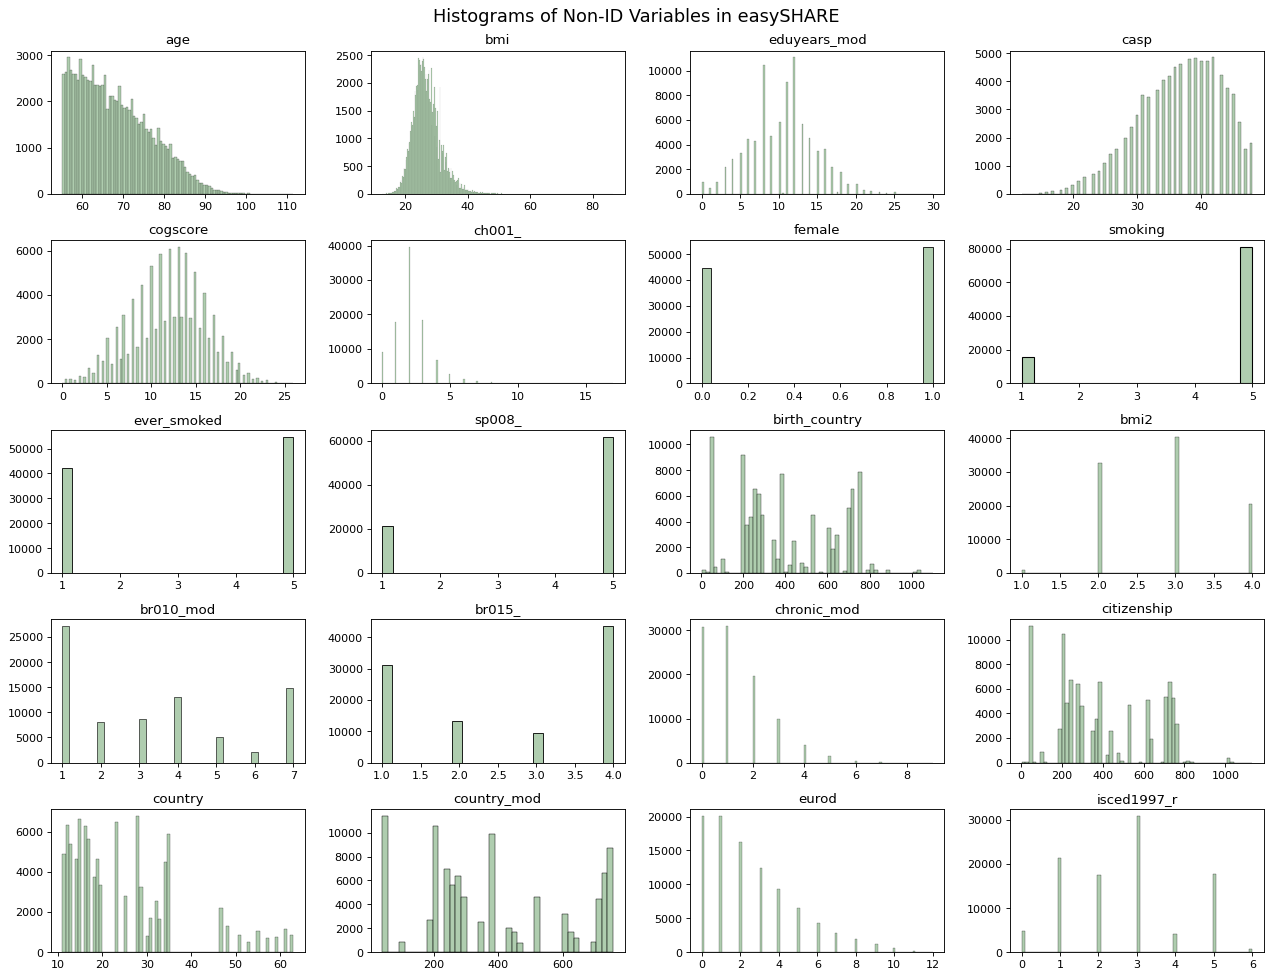

In [5]:
# df.info()   # no missing values

# List of columns per type of variable
id_vars = ['int_year','wave','mergeid']     # ID variables
numerical_vars = ['age','bmi','eduyears_mod','casp','cogscore','ch001_']     # Non-categorical variables
binary_vars = ['female','smoking','ever_smoked','sp008_']     # Binary variables
cat_vars = np.setdiff1d(df.columns,id_vars + numerical_vars + binary_vars).tolist()     # Categorical variables (n>2)

#len(cat_vars+binary_vars+numerical_vars+id_vars)==len(df.columns) # Checking no variables are missing

# Explore variable distributions through histograms
non_id_vars = numerical_vars + binary_vars + cat_vars # Get vector of all variables to plot with histograms

# Figure plot area and settings
fig, ax = plt.subplots(figsize = (16, 12))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# For loop to create histograms
for n, col in enumerate(non_id_vars):
    plt.subplot(5, 4, n+1)
    a = sns.histplot(df[col],ax = plt.gca(),color='#95bd95')
    a.set(xlabel=None, ylabel=None)
    a.set_facecolor('white')
    plt.title(col)

plt.tight_layout()
plt.suptitle("Histograms of Non-ID Variables in easySHARE", fontsize=16, y=1.015)

Apparent in the histograms above, the features in easySHARE follow a variety of distributions. Specifically, most do not present a normal -or similar- distribution. Some of the histograms are heavy-tailed, meaning their tails hold more weight than a normal, or they are skewed, meaning they extend farther to the right of the median than to the left (or vice versa). This may make it harder for some algorithms to detect patterns. These characteristics suggest we should consider normalising the data by performing Box-Cox transformations.

Moreover, it is worth mentioning that a good proportion of our available features are skewed count or categorical variables (some of which have significant density at value 0, as is the case with *eurod* and *chronic_mod*). Adequately managing these features' characteristics requires some additional subtlety, especially when handling their outliers and transforming them to more normal-like distributions to be able to do inference with their coefficients in the models.

To better understand the peculiarities of the variables in our dataset and which transformations may be necessary prior to the modelling stage, we will proceed to explore the boxplots of the available features.


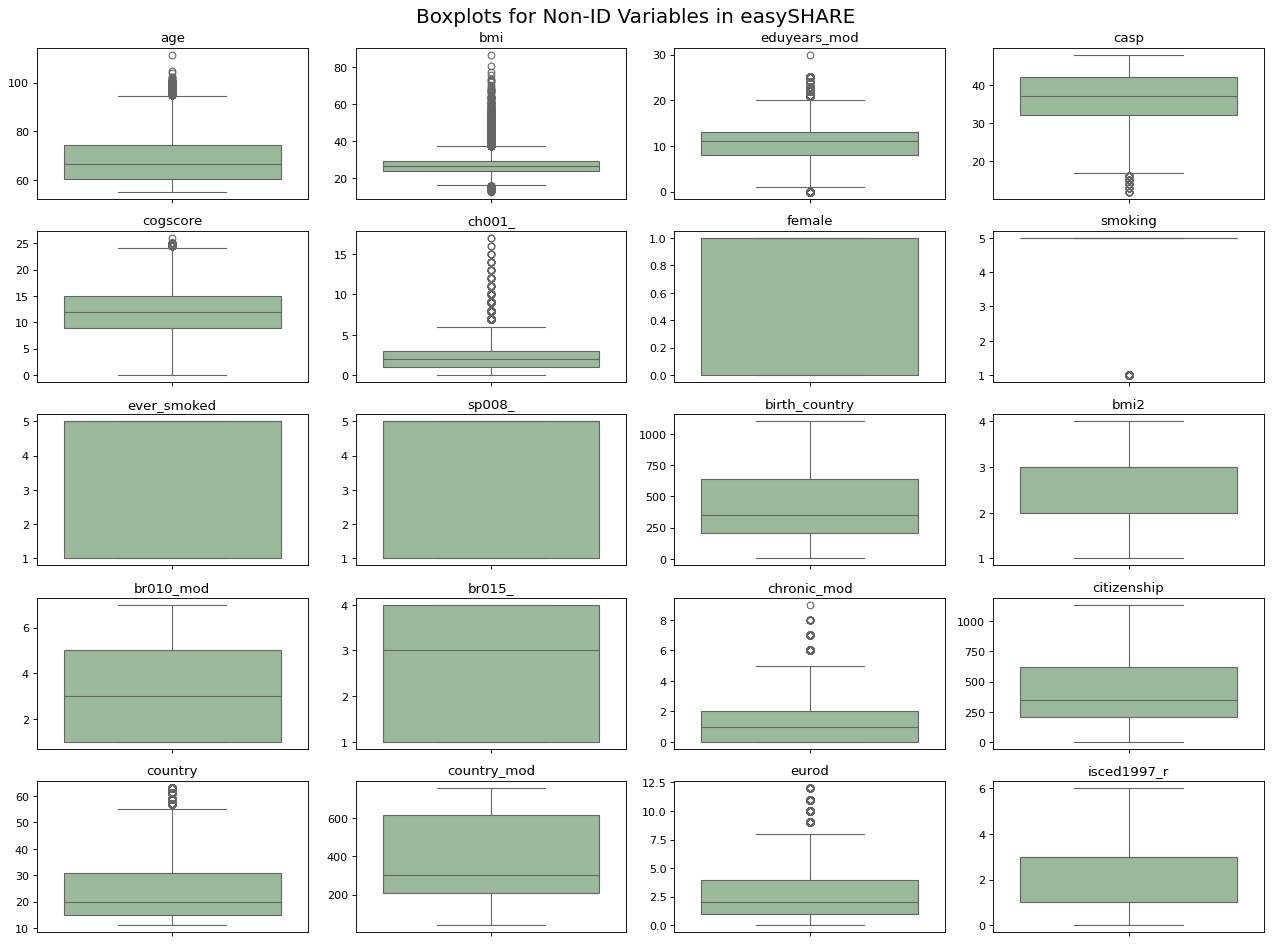

In [6]:
# Generating Box-Plots for Non-ID Variables
fig, axes = plt.subplots(figsize = (16, 12), ncols = 4, nrows=5, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = df[non_id_vars].values[:,i], ax = ax, color='#95bd95') 
    ax.set_title(non_id_vars[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Non-ID Variables in easySHARE", fontsize=18)
plt.tight_layout()

As stated above, some of the dataset's features have a significant number of outliers. It is worth differentiating the outlier treatment we suggest for these variables:

- *age*: Given we want to estimate dementia severity, which is tightly linked to age, removing the outliers for this variable would be detrimental to the data as it would reduce the capacity of our model to estimate dementia severity for people in higher percentiles of age which is where dementia is more prevelant.

- *bmi*: This variable appears to have a significant number of outliers, however all of which are important data points.  We cannot discount these points in favour of a nicer distribution to work with. Instead, its categorical transformation *bmi2* will be used. It has a more intuitive interpretation in a prediction model.

- *eurod*: This variable is a categorical feature that represents how depressed the surveyed individual is. Thus, removing its outliers would remove the more extreme categories (i.e.: 12 stands for 'very depressed') and therefore reduce the capacity of our model to estimate dementia severity for people most affected by depression.

- *casp*: The outliers in this variable, which is an index representing quality of life, are found in the lower-end of its distribution. These points would be associated to a higher risk of high dementia severity. For this reason, similar to the logic used for the previous variable, we decide to keep the outliers.

- *eduyears_mod*, *ch001_* and *chronic_mod*: Given these variables are counts (education years, number of children and number of chronic diseases) whose extremes may not be as useful to distinguish from its upper values (i.e.: Someone with a PhD education would most likely have a similar dementia severity prediction based on this feature alone that someone with a post-Doctoral degree), we suggest handling these outliers through winsorization, as is suggested for skewed counts<sup>6</sup>.

## Data Cleaning

We proceed to cleaning our data in order to explore if winsorization does indeed improve the outliers in these distributions.

In [7]:
# Creating a copy of dataframe where all data cleaning and transformations will be stored
df_transformations = df.copy()

# Drop the null values
df_transformations = df_transformations.dropna()

In [8]:
# Winsorizing eduyears_mod, chronic_mod and ch001_
# Finding the 99th (upper bound) and 1st (lower bound) percentiles for each variable to winsorize

# Bounds for years of education
upper_lim_edu = df['eduyears_mod'].quantile(0.99)
lower_lim_edu = df['eduyears_mod'].quantile(0.01)

# Bounds for chronic diseases    
upper_lim_chr = df['chronic_mod'].quantile(0.99)
lower_lim_chr = df['chronic_mod'].quantile(0.01)

# Bounds for number of children
upper_lim_child = df['ch001_'].quantile(0.99)
lower_lim_child = df['ch001_'].quantile(0.01)

# Replacing original variables with winsorized vectors
df_transformations['eduyears_mod'] = np.where(df_transformations['eduyears_mod'] >= upper_lim_edu,
                        upper_lim_edu,
                        np.where(df_transformations['eduyears_mod'] <= lower_lim_edu,
                        lower_lim_edu,
                        df_transformations['eduyears_mod']))

df_transformations['chronic_mod'] = np.where(df_transformations['chronic_mod'] >= upper_lim_chr,
                        upper_lim_chr,
                        np.where(df_transformations['chronic_mod'] <= lower_lim_chr,
                        lower_lim_chr,
                        df_transformations['chronic_mod']))

df_transformations['ch001_'] = np.where(df_transformations['ch001_'] >= upper_lim_child,
                        upper_lim_child,
                        np.where(df_transformations['ch001_'] <= lower_lim_child,
                        lower_lim_child,
                        df_transformations['ch001_']))

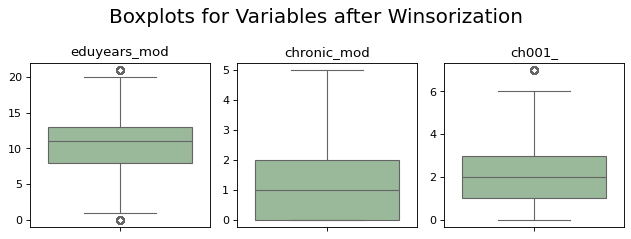

In [9]:
# Generating boxplots after winsorization

# Vector of variables that were winsorized
winsor_vars = ['eduyears_mod','chronic_mod','ch001_']

fig, axes = plt.subplots(figsize = (8, 3), ncols = 3, nrows=1, sharex = True)
axes = axes.flatten()
winsor_vars_values = df_transformations[winsor_vars].values

for i, ax in enumerate(axes):
    sns.boxplot(y = winsor_vars_values[:,i], ax = ax, color='#95bd95') 
    ax.set_title(winsor_vars[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Variables after Winsorization", fontsize=18)
plt.tight_layout()


Indeed, winsorizing *eduyears_mod*, *chronic_mod* and *ch001_* with their 99th and 1st percentiles as bounds helped to regularise the outliers for these features. 

## Data Transformation

We will now explore the normality for the standardised version of the numerical features (count and continuous variables) in our dataset.

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 0.98, 'Q-Q Plots of Numerical Variables in easySHARE')

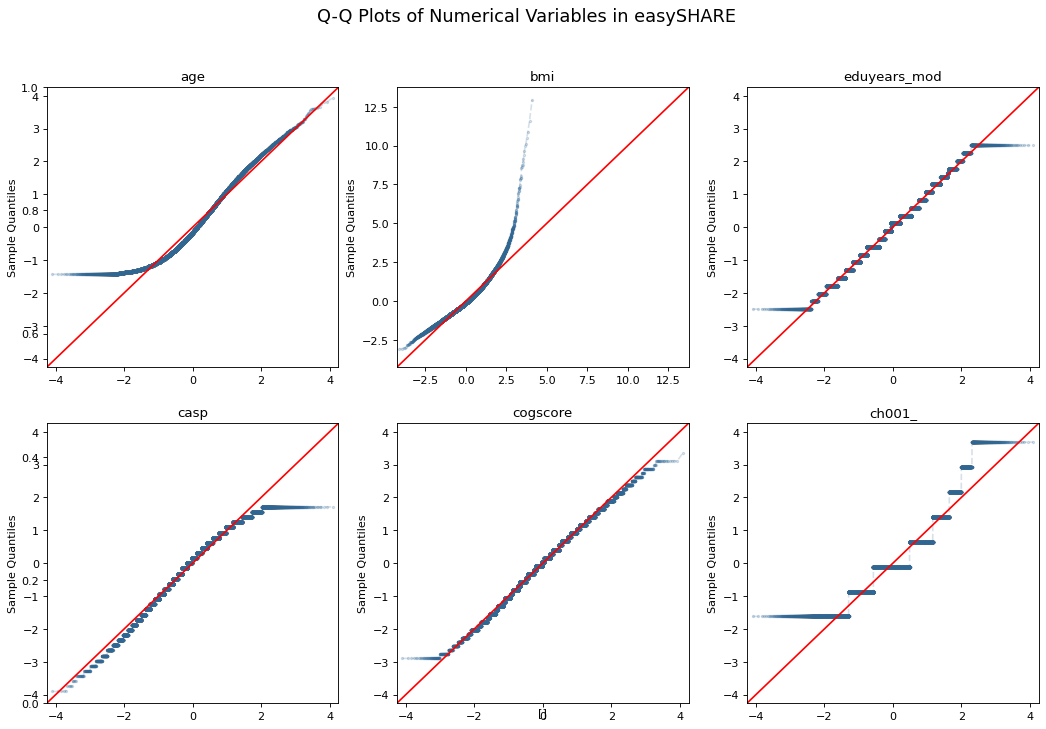

In [10]:
# Q-Q Plot Exploration of Normality for Numerical Variables in easySHARE

# Standardisation of the numerical variables
std_numerical_df = df_transformations[numerical_vars].values
std_numerical_df = pp.StandardScaler().fit_transform(std_numerical_df)
std_numerical_df = pd.DataFrame(std_numerical_df, columns=numerical_vars)

fig, axs = plt.subplots(figsize=(16, 10))
axs.set_frame_on(False)
axs.set_xticks([])
axs.set_xlabel([])

for n, col in enumerate(numerical_vars):
    plt.subplot(2, 3, n+1)
    sm.qqplot(std_numerical_df[col], ax=plt.gca(), line='45', fit=False,
                **{'markersize':2, 'alpha':0.2,'markeredgecolor':'#3a6791',
                'linestyle':'dashed','color':'#3a6791'})
    plt.title(col)
    plt.xlabel('')

fig.suptitle('Q-Q Plots of Numerical Variables in easySHARE', fontsize=16)

The numerical features in our dataset resemble somewhat skewed normal distributions with tails that are fatter/lighter than the normal, depending on the variable. Particularly, *bmi* is the farthest away from a normal distribution. This was to be expected because of the heavy prevalence of outliers that were identified in the earlier shown boxplot of the variable. Furthermore, the count variables (*ch001_* and *eduyears_mod*) have more of a step-wise distribution with lower boundaries positioned above a normal that accumulate more density (cannot have less than 0 children or years of education) and some outliers on the higher extreme.

To improve the skewness present in our variables and allow for inference during the modelling stage, we will proceed to evaluate Box-Cox transformations for our numerical variables by finding the $\lambda$ that maximises the log-likelihood function. It is relevant to note that 0.01 will be added to the count variables prior to the $\lambda$ optimisation, given that these have significant density at value 0 and $\log(0)$ is not defined<sup>7</sup>. 

In [11]:
# Finding optimal lambda for non-normal variables.
age_box_, bc_age_param = stats.boxcox(df_transformations['age'].astype(int), lmbda = None)
print(f'The lambda that maximises the log-likelihood function for the variable age is {round(bc_age_param,2)}.')

cs_box_, bc_cs_param = stats.boxcox(df_transformations['cogscore'].astype(float), lmbda = None)
print(f'The lambda that maximises the log-likelihood function for the variable cogscore is {round(bc_cs_param,2)}.')

casp_box_, bc_casp_param = stats.boxcox(df_transformations['casp'].astype(float), lmbda = None)
print(f'The lambda that maximises the log-likelihood function for the variable casp is {round(bc_casp_param,2)}.')

bmi_box_, bc_bmi_param = stats.boxcox(df_transformations['bmi'].astype(float), lmbda = None)
print(f'The lambda that maximises the log-likelihood function for the variable bmi is {round(bc_bmi_param,2)}.')

eduyrs_box_, bc_eduyrs_param = stats.boxcox((df_transformations['eduyears_mod']+0.01).astype(float), lmbda = None)
print(f'The lambda that maximises the log-likelihood function for the variable eduyears_mod is {round(bc_eduyrs_param,2)}.')

ch001_box_, bc_ch001_param = stats.boxcox((df_transformations['ch001_']+0.01).astype(float), lmbda = None)
print(f'The lambda that maximises the log-likelihood function for the variable ch001_ is {round(bc_ch001_param,2)}.')

The lambda that maximises the log-likelihood function for the variable age is -1.56.
The lambda that maximises the log-likelihood function for the variable cogscore is 1.06.
The lambda that maximises the log-likelihood function for the variable casp is 2.04.
The lambda that maximises the log-likelihood function for the variable bmi is -0.52.
The lambda that maximises the log-likelihood function for the variable eduyears_mod is 0.87.
The lambda that maximises the log-likelihood function for the variable ch001_ is 0.63.


/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


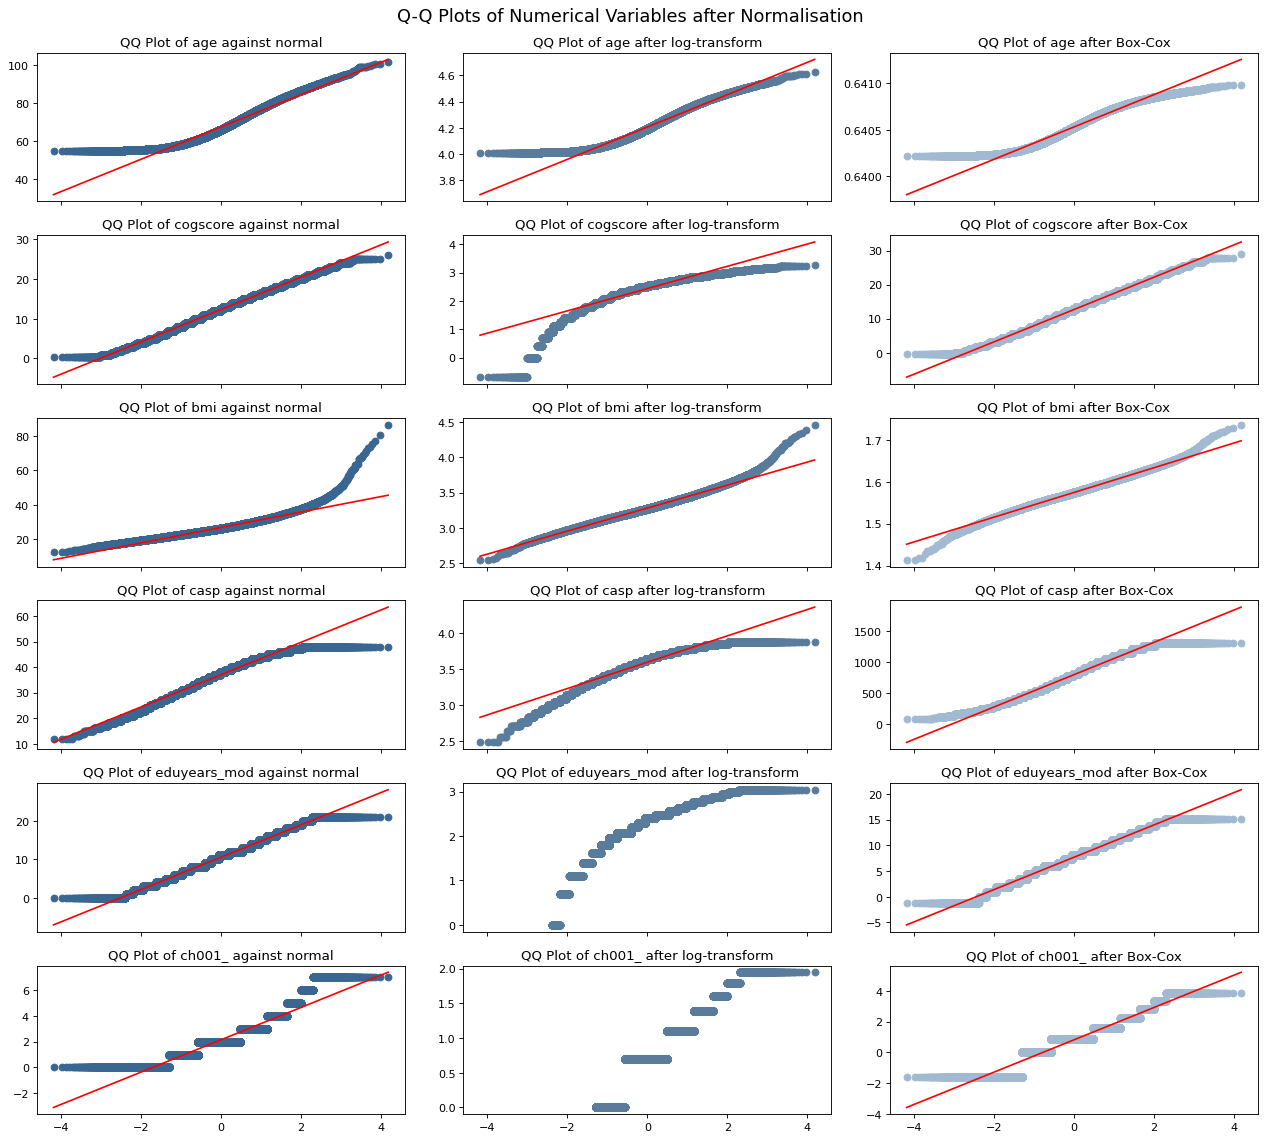

In [12]:
# Adapted from Feature Engineering for Machine Learning principles and techniques for data scientists

# List of variables to which we apply Box-Cox transformations
boxcox_list = ['age', 'cogscore', 'bmi', 'casp', 'eduyears_mod', 'ch001_']

# Dataframe with columns we apply Box-Cox transformation to
boxcox_df = df_transformations[boxcox_list]
df_trans_copy = df_transformations[non_id_vars]

# List of optimal lambda parameters
best_lambdas = [bc_age_param, bc_cs_param, bc_bmi_param, bc_casp_param, bc_eduyrs_param, bc_ch001_param]

# Graph to compare QQ Plots pre and post log-transformation and
# Box-Cox transformation using optimal lambda from prior code
fig2, axs = plt.subplots(6, 3, figsize=(16,14), sharex=True) 

# For loop to create 3 comparison plots for each variable
for i in range(len(axs)):
    # QQ Plot of Original Variable Data
    prob1 = stats.probplot(boxcox_df[boxcox_list[i]].astype(float), dist=stats.norm, 
    plot=axs[i][0])     # Plot original data 
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('') 
    axs[i][0].set_title(f'QQ Plot of {boxcox_list[i]} against normal') 
    axs[i][0].get_lines()[0].set_markerfacecolor('#3a6791')
    axs[i][0].get_lines()[0].set_markeredgecolor('#3a6791')

    # QQ Plot of Log-Transformed Variable Data
    var_logtrans_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=0.)
    prob2 = stats.probplot(var_logtrans_, dist=stats.norm, plot=axs[i][1]) 
    axs[i][1].set_xlabel('') 
    axs[i][1].set_ylabel('') 
    axs[i][1].set_title(f'QQ Plot of {boxcox_list[i]} after log-transform')
    axs[i][1].get_lines()[0].set_markerfacecolor('#5a7c9c')
    axs[i][1].get_lines()[0].set_markeredgecolor('#5a7c9c')

    # QQ Plot of Box-Cox Transformed Variable Data
    var_boxcox_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=best_lambdas[i])
    prob3 = stats.probplot(var_boxcox_, dist=stats.norm, plot=axs[i][2]) 
    axs[i][2].set_xlabel('') 
    axs[i][2].set_ylabel('') 
    axs[i][2].set_title(f'QQ Plot of {boxcox_list[i]} after Box-Cox')
    axs[i][2].get_lines()[0].set_markerfacecolor('#a1bad1')
    axs[i][2].get_lines()[0].set_markeredgecolor('#a1bad1')

plt.tight_layout()
fig2.suptitle('Q-Q Plots of Numerical Variables after Normalisation', fontsize=16, y=1.015)
plt.show()

From the normalisation of these variables, we can identify that the feature *bmi* has significantly benefitted from the transformation. In general, log-transformation was not beneficial for any of the variables, and for the rest of the numerical features, Box-Cox transformation using their optimal $\lambda$ did not significantly improve the normality (they were visibly close enough to a normal).

To implement the last steps of our feature engineering process, we will proceed to transform the categorical variables *bmi2*, *br010_mod* and *br015_*, which currently have categories in numerical scales, to string variables with the interpretation of each category to have them in a format that allows for OneHotEncoding.

In [13]:
# Replacing smoking value 5 (non-smoker) for 0.
for i in binary_vars:
    df_transformations[i] = np.where(df_transformations[i] == 5, 0,df_transformations[i])

bmi2_vals = ['underweight','normal','overweight','obese']
br010_vals = ['no_drink','less1mo_drink','cple1mo_drink','cple1wk_drink',
            '4wk_drink','6wk_drink','daily_drink']
br015_vals = ['more1wk_act','1wk_act','mnthly_act','hardly_act']

df_transformations['bmi2'] = np.where(df_transformations['bmi2'].astype(int)==1,
                        bmi2_vals[0],
                        np.where(df_transformations['bmi2'].astype(int)==2,
                        bmi2_vals[1],
                        np.where(df_transformations['bmi2'].astype(int)==3,
                        bmi2_vals[2],
                        bmi2_vals[3])))

df_transformations['br015_'] = np.where(df_transformations['br015_'].astype(int)==1,
                        br015_vals[0],
                        np.where(df_transformations['br015_'].astype(int)==2,
                        br015_vals[1],
                        np.where(df_transformations['br015_'].astype(int)==3,
                        br015_vals[2],
                        br015_vals[3])))

df_transformations['br010_mod'] = np.where(df_transformations['br010_mod'].astype(int)==1,
                        br010_vals[0],
                        np.where(df_transformations['br010_mod'].astype(int)==2,
                        br010_vals[1],
                        np.where(df_transformations['br010_mod'].astype(int)==3,
                        br010_vals[2],
                        np.where(df_transformations['br010_mod'].astype(int)==4,
                        br010_vals[3],
                        np.where(df_transformations['br010_mod'].astype(int)==5,
                        br010_vals[4],
                        np.where(df_transformations['br010_mod'].astype(int)==6,
                        br010_vals[5],
                        br010_vals[6]))))))

## Data Partitioning

We proceed to splitting the data into training and testing sets before exploring the correlations between the variables in the dataset.

In [14]:
# Set a seed for reproducibility of results
rng = np.random.seed(21701)

# First split off features and targets
features = ['age','bmi','eduyears_mod','casp','ch001_','female',
            'smoking','ever_smoked','sp008_','bmi2','br010_mod',
            'br015_','chronic_mod','eurod','isced1997_r']

X = df_transformations[features]
y = df_transformations['cogscore']

# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

Having split our data into training and testing set, we finally explore the correlations matrix of the observed features.  Taking the correlation between features into consideration is important prior to the modelling stage for numerous reasons. Firstly, it helps reduce collinearity by highlighting the features that are highly correlated and would effect the model's accuracy if both were used. Correlation also allows us to idenify which features are highly correlated and hopefully predictive of our desired variable, *cogscore*.

Text(0.5, 0.95, 'Heatmap of Non-ID Variables in easySHARE')

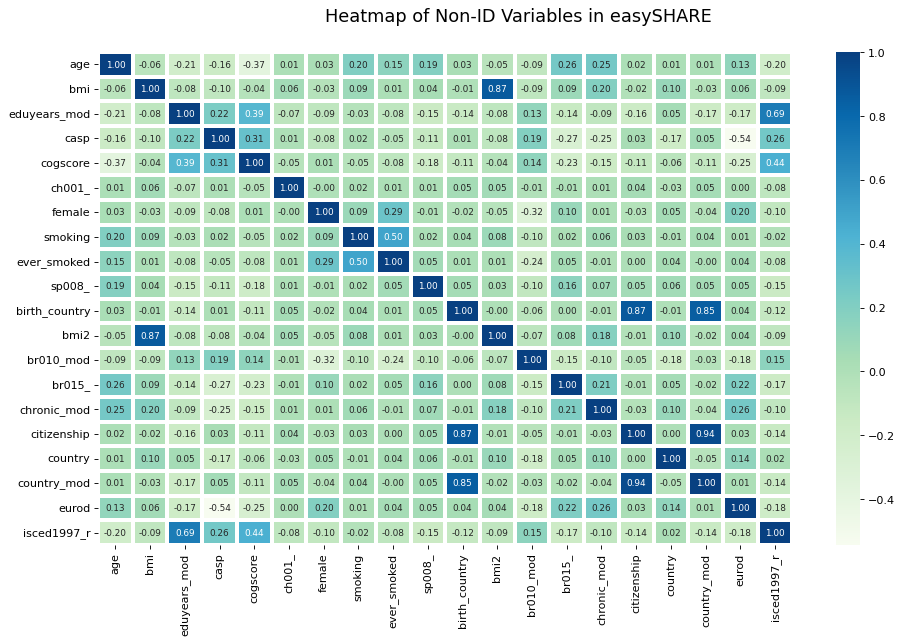

In [15]:
# Plot a heat map to check if any of the features are correlated
rcParams['figure.figsize'] = 14,8
#sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df_trans_copy.corr(),cmap="GnBu", annot = True,
            fmt = '.2f',  linewidths = 2, annot_kws={"size": 8})
plt.suptitle('Heatmap of Non-ID Variables in easySHARE',fontsize=16,y=0.95)


As expected, *birth_country*, *country_mod* and *citizenship* have a high positive correlation; as do *eduyears_mod* and *isced1997_r* (ISCED-97 coding of education level), and *bmi* and *bmi2*. This serves as a reminder to choose only one of the representation of demographic factors (continuous vs categorical). Additionally, *eurod* (depression level) and *casp* (quality of life) seem to have medium correlation. Other than this, factors do not seem to have high correlation amongst themselves, thus, it is not evident from the start that any of the other variables could bring collinearity issues to the models. 

Moreover, we can observe that there is some correlation ($\geq$ $\lvert0.2\rvert)$) between our dependent variable of interest, *cogscore*, and the following variables:

- **Education**: *isced1997_r* and *eduyears_mod*
- **Depression**: *eurod*
- **Physical activity**: *br015_*
- **Age**: *age*
- **Quality of life**: *casp*

We will proceed to investigate the scatter plots between *cogscore* and each of these variables in order to identify possible model functional forms.

Text(0.5, 1.02, 'Scatter Plot of Variables Correlated to Cognitive Score')

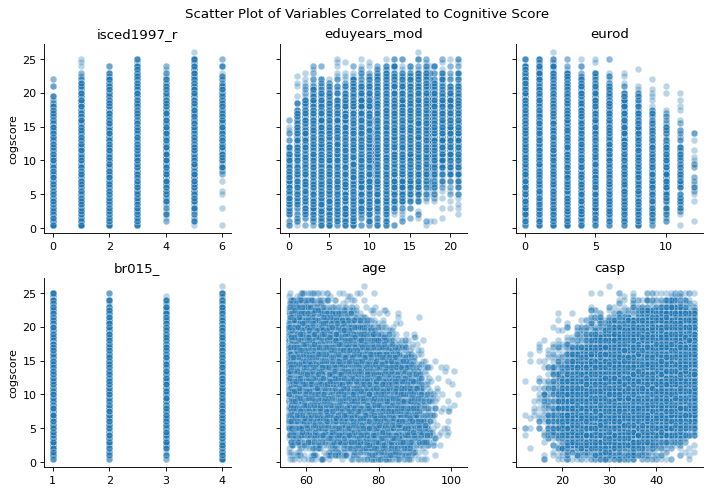

In [16]:
# "Pairplot" equivalent
vars_corr = ['isced1997_r','eduyears_mod','eurod',
                      'br015_','age','casp']
vars_corr_cs = vars_corr + ['cogscore']                      
corr_df = df_trans_copy[vars_corr_cs]

# Creating Facet Grid
g = sns.FacetGrid(pd.DataFrame(vars_corr), col=0, col_wrap=3, sharex=False)
# Plotting scatterplots
for ax, varx in zip(g.axes, vars_corr):
    sns.scatterplot(data=corr_df, x=varx, y="cogscore", ax=ax,
    alpha=0.3).set_title(varx)
    ax.set_xlabel("")

plt.suptitle('Scatter Plot of Variables Correlated to Cognitive Score', y=1.02)
# # g.tight_layout()

At first glance, no obvious functional forms are apparent between our possible continuous independent variables and *cogscore*. However, we would expect an inverse relationship between *age* and *cogscore* (as we would expect cognitive score to lower as people age), and a direct relationship between *casp*/*eduyears_mod* and *cogscore* (as it to be expected: on average higher cognitive score for people with higher life quality and education). Thus, taking note of the results of our correlation matrix and scatter plots, we will proceed to the modelling stage of the study.

# Model Fitting and Tuning


Following the feature engineering process, we now begin building our model. From the data exploration phase we learned which features are highly correlated with each other, meaning we only need one of them, and which are highly correlated with our depended feature *cogscore*, meaning they definitely should be in the model. Since the scatterplots above did not yield any more information regarding correlation with *cogscore* we will focus on the features that we highlighted from the correlation matrix and were highlighted in the literature:
- obesity
- smoking
- education
- drinking behavior
- physical activity level
- quality of life
- age

## Baseline Model

In [17]:
# Baseline features
baseline_features = ['eduyears_mod', 'casp','age','eurod','smoking']
X_train_bs, X_test_bs = X_train[baseline_features], X_test[baseline_features]

# Setting up the pipeline for the baseline model
num_pre = Pipeline([
    ("num_scale", StandardScaler())])

baseline_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([("numerical", num_pre, [0,1,2,3]),
                                         ("binary", "passthrough", [4])])),
    ("model", LinearRegression())
])

baseline_model = baseline_pipe.fit(X_train_bs,y_train)
coef_col_names_bs=['intercept','eduyears_mod', 'casp',
                        'age','eurod','smoking']
coefs0 = pd.DataFrame([get_coefs(baseline_model)],
                        columns=coef_col_names_bs).transpose()

coefs0.rename(columns={coefs0.columns[0]: "Coefficients"}, inplace = True)

In [18]:
# Calculating statistical significance of baseline coefficients
params = get_coefs(baseline_model)
predictions = baseline_model.predict(X_train_bs)

new_X = pd.DataFrame({"Constant":np.ones(len(X_train_bs))}).join(pd.DataFrame(X_train_bs.reset_index(drop=True)))
MSE = (sum((y_train - predictions)**2))/(len(new_X) - len(new_X.columns))

var_b = MSE * (np.linalg.inv(np.dot(new_X.transpose(), new_X)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/sd_b

p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(new_X) - len(new_X.columns)))) for i in ts_b]

sd_b = np.round(sd_b, 3)
ts_b = np.round(ts_b, 3)
p_values = np.round(p_values, 3)
params = np.round(params, 4)

bs_summary = pd.DataFrame()
bs_summary["Factors"], bs_summary["Coefficients"], bs_summary["SDE"], bs_summary["T-Values"], bs_summary["P-Values"] = [coef_col_names_bs, params, sd_b, ts_b, p_values]
bs_summary = bs_summary.set_index(['Factors'])
# Formatting
bs_summary_df = bs_summary.style.format('{}')
bs_summary_df.set_table_styles([index_names, headers])

## NOTE: Confirmed the coefficients are equal to the sklearn Linear Regression ran above.

,Coefficients,SDE,T-Values,P-Values
Factors,,,,
intercept,12.3235,0.216,56.932,0.0
eduyears_mod,1.1366,0.004,258.151,0.0
casp,0.6653,0.003,198.659,0.0
age,-1.1469,0.002,-533.838,0.0
eurod,-0.3367,0.009,-36.286,0.0
smoking,-0.1818,0.048,-3.772,0.0


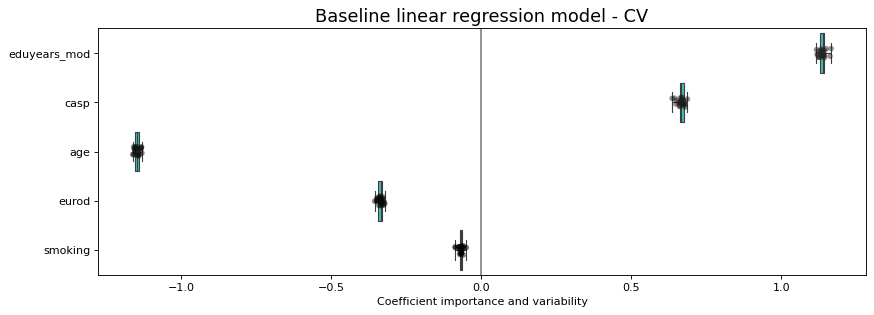

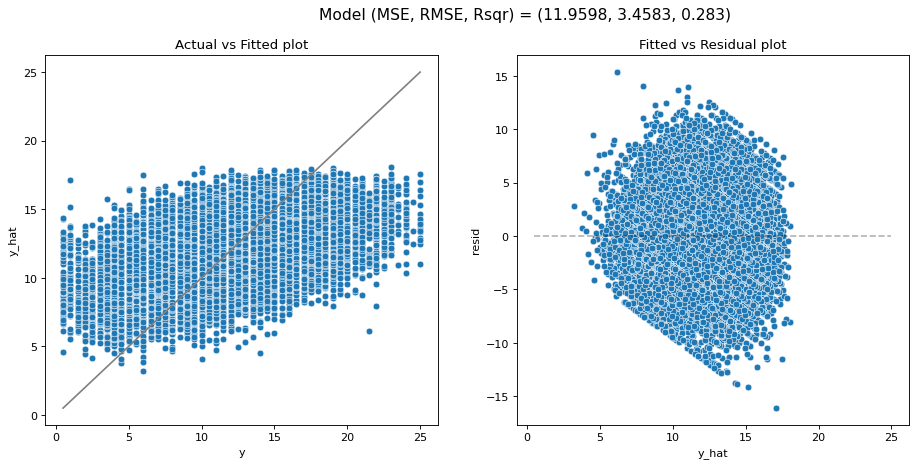

(11.9598, 3.4583, 0.283)

In [19]:
# Coefficient Variability Analysis
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    baseline_model,
    X_train_bs,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(X_train_bs.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_train_bs, y_train))
    ],
    columns=baseline_features,
)

plt.figure(figsize=(16, 4))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance and variability")
plt.title("Baseline linear regression model - CV",fontsize=16)
plt.subplots_adjust(left=0.3)

# Model fit
baseline_MSE, baseline_RMSE, baseline_R2 = model_fit(baseline_model, X_train_bs, y_train, plot = False)
model_fit(baseline_model, X_train_bs, y_train, plot = True)

In our baseline model, all the factors are statistially significant. As we would expect, more years of education, higher quality of life and the intercept all have a positive relationship with cognitive score (a higher cognitive score is being used as a proxy for lower dementia severity). On the contrary, the age of an individual, higher depression and smoking habits have a negative relationship with cognitive score (positive relationship with dementia).

Additionally, our baseline model has an R-squared of 28.3% for the training dataset, and as we can see in its plots, this model would not be very reliable to predict the relationship between our independent variables and our dependent variable, cogscore. It is important to note that there does not seem to be any evident linear relationship between the chosen independent variables and the target variable.

## Further Models

Seeking to improve our model performance, we proceeded to use a sequential feature selector (SFS) algorithm to determine which features from the easySHARE database would maximise the performance of our model. This algorithm belongs to a family of greedy search algorithms which seek to perform feature dimension reduction - it identifies a subset of the most relevant features with the aim of enhancing computational efficiency and minimising model error. For this study, we chose to perform *forward selection* of features with *mean squared error* as the criteria. The SFS model is initiated with $0$ features and in each iteration of the fitting, it selects the best single feature that minimises the mean squared error of the model. Once the minimum has been achieved, no additional features are added to the model and the algorithm terminates with a vector of selected features.

In the case of this study, this algorithm yielded the selection of the following features:

In [20]:
# Sequential Feature Selection
onehot_encoder = OneHotEncoder(drop='first')

encoder = ColumnTransformer([
    # pass through all columns with numerical values 
    ("num", "passthrough", [0,1,2,3,4,5,6,7,8,12,13,14]), 
    # apply the onehot_encoder to the last column
    ("cat", onehot_encoder, [9,10,11]),
]) 

names_post_encoding = ['age','bmi','eduyears_mod','casp','ch001_','female',
                       'smoking','ever_smoked','sp008_','normal','overweight',
                       'obese','less1mo_drink','cple1mo_drink','cple1wk_drink',
                       '4wk_drink','6wk_drink','daily_drink','1wk_act','mnthly_act',
                       'hardly_act','chronic_mod','eurod','isced1997_r']

X_train_1hot = encoder.fit_transform(X_train)
X_test_1hot = encoder.fit_transform(X_test)

sfs = SequentialFeatureSelector(LinearRegression(),
                                direction='forward',
                                scoring='neg_mean_squared_error')

sfs_selector = sfs.fit(X_train_1hot, y_train)
selected_columns = sfs_selector.get_support()

X_train_best = sfs_selector.transform(X_train_1hot)
X_test_best = sfs_selector.transform(X_test_1hot)

# Columns selected by Sequential Feature Selector
selected_cols_index = (selected_columns*1).tolist()
selected_features = [x for i, x in enumerate(names_post_encoding) if selected_cols_index[i]]
selected_features_df = pd.DataFrame(selected_features,columns=['Selected Features'])
selected_features_df = selected_features_df.style.format('{}')
selected_features_df.set_table_styles([index_names, headers])

,Selected Features
0,age
1,eduyears_mod
2,casp
3,female
4,smoking
5,ever_smoked
6,sp008_
7,overweight
8,obese
9,1wk_act


In line with literature (*Lancet 2017 and 2020*), the SFS algorithm selected indicators of age, education, smoking habits, social contact, obesity, physical activity and other chronic diseases as significant factors to predict dementia severity. Moreover, it selected *casp*, a life quality indicator which in this study's data exploration phase was shown to have a $-0.54$ correlation with depression indicators, thus there is some merit to including only the best predictor of these two variables in the models for dementia severity.
 
The previously listed features are used as the independent variables in the rest of our evaluated models, which include:

- **Polynomial Regression**: This model was used to detect possible non-linear relationships between the factors and dementia severity. A grid search was performed to determine the best fitting polynomial degree, resulting in a second-degree polynomial model. 

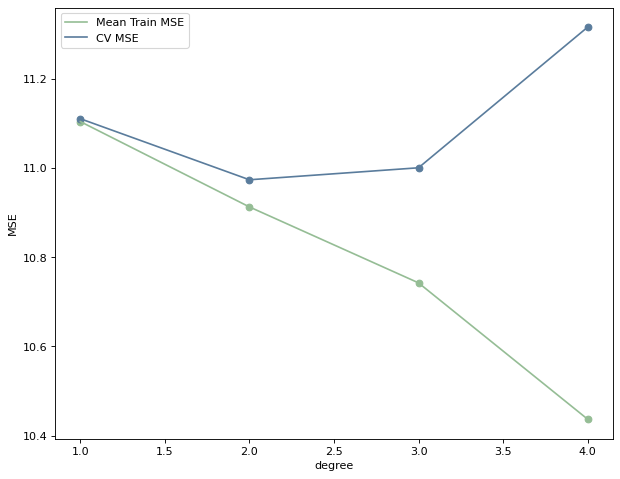

In [26]:
pf = PolynomialFeatures(include_bias=False)

# Overall ML pipeline
poly_pipe = Pipeline([
    ("poly", pf),
    ("model", LinearRegression())])

# Parameters for grid search
parameters = {
    'poly__degree': np.arange(1, 5, 1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=rng)

grid_search = GridSearchCV(poly_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train_best, y_train)

pd.DataFrame(grid_search.cv_results_)

degree = np.arange(1, 5, 1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='#95bd95')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='#95bd95', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='#5a7c9c')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='#5a7c9c', label='CV MSE')
ax.legend()
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

# it seems like we should stick to degree 2
poly_model = poly_pipe.fit(X_train_best, y_train)

model_fit(poly_model, X_train_best, y_train, plot=False)

# grid_search.fit(X_train_best, y_train)

poly_MSE, poly_RMSE, poly_R2 = model_fit(grid_search.best_estimator_, X_test_best, y_test, plot=False)


- **Ridge Regression**: This model was chosen to contemplate the possibility that some of the features selected could still have coefficients that could be shrinked near to zero, which would allow us to more clearly identify which are the factors that policy-makers must focus on with the highest priority.

In [22]:
# Grid of tuning parameters
alphas = np.linspace(0, 20, num=150)  

#Pipeline
ridge_pipe = make_pipeline(
        StandardScaler(),
        Ridge())

# CV strategy
cv = KFold(5, shuffle=True, random_state=rng)

# Grid search
gs = GridSearchCV(ridge_pipe,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")

gs.fit(X_train_best, y_train)

ridge_MSE, ridge_RMSE, ridge_R2 = model_fit(gs.best_estimator_, X_test_best, y_test, plot=False)

- **Elastic Net Regression**: We also evaluated this model with the same goal of the *Ridge Regression*, but taking into consideration it would output some of the coefficients as zero, making the most relevant features even clearer.

In [23]:
alpha_val = np.arange(1, 100, 1)
MSE = []

for alpha in alpha_val:
    r = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha = alpha, random_state=rng)
    ).fit(X_train_best, y_train)

    MSE.append(model_fit(r, X_train_best, y_train)[0])

best_alpha_EN = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha = np.argmin(MSE), random_state=rng)
    ).fit(X_train_best, y_train)

EN_MSE, EN_RMSE, EN_R2 = model_fit(best_alpha_EN, X_train_best, y_train,plot=False)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+05, tolerance: 6.340e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

- **Random Forest Regression**: Given the Random Forest algorithm's known strength of handling datasets with continuous and categorical variables, the present study evaluated using this model seeking to improve prediction accuracy with the algorithm's "wisdom of the crowds" approach.

In [29]:
rand_forest_reg = RandomForestRegressor(max_depth=2, random_state=rng)
rand_forest_reg.fit(X_train_best, y_train)

RF_MSE, RF_RMSE, RF_R2 = model_fit(rand_forest_reg, X_train_best, y_train, plot=False)

- **Histogram-Based Gradient Boosting Regression**: In a similar fashion, we choose a histogram-based gradient boosting regression to exploit the *gradient boosting (GB) algorithm's* ability to combine the predictive power of multiple weak learners, building sequential simple models to reduce the errors of the previous model. Amongst this type of algorithms, the histogram-based GB is a machine learning technique that "accelerates the training of gradient boosted trees by leveraging histograms and integer-based data structures"<sup>8</sup>, which for our purpose achieves a computationally efficient GB regression.

Particularly, we choose our final model to be the Histogram-Based Gradient Boosting (HBGB) Regression, as its focus on predictive power could better aid us in our quest to identify the most relevant factors for dementia severity, with the aim of helping policy-makers focus their efforts.

For this reason, we proceed to do a grid search with K-Fold cross-validation (5 folds with shuffling) to find the optimal learning and tree parameters for our model. We then proceed to fit our model with the training dataset of the features selected earlier by the SFS algorithm.

In [25]:
# GRADIENT BOOSTING, THE ONE <3
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('hist_gb', HistGradientBoostingRegressor(random_state=rng))  # HistGradientBoostingRegressor for regression
])

gb_reg = gb_pipeline.fit(X_train_best, y_train)

# model_fit(gb_reg, X_train_best, y_train, plot=True)
#model_fit(gb_reg, X_test_best, y_test, plot=True)

# Define cross-validation strategy, for example, KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=rng)

# Perform cross-validation and get the R^2 scores
# cross_val_scores_gb = cross_val_score(gb_reg, X_train_best, y_train, cv=kf, scoring='r2')

# Print the cross-validation scores
# print("Cross-Validation Scores:", cross_val_scores)
# print("Mean R^2 Score:", np.mean(cross_val_scores))

# Define the parameter grid to search
param_grid = {
    'scaler__with_mean': [True, False],  # StandardScaler parameter
    'scaler__with_std': [True, False],   # StandardScaler parameter
    'hist_gb__learning_rate': [0.01, 0.1, 0.2],
    'hist_gb__max_iter': [100, 200, 300],
    'hist_gb__max_depth': [3, 5, 7],
    'hist_gb__min_samples_leaf': [1, 5, 10],
    'hist_gb__max_leaf_nodes': [15, 31, 50],
}

# # Perform grid search with cross-validation
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_best, y_train)

# # Print the best parameters and corresponding score
# print("Best Parameters:", grid_search.best_params_)
# print("Best R**2:", grid_search.best_score_)
# # Best Parameters: {'hist_gb__learning_rate': 0.1, 'hist_gb__max_depth': 7, 'hist_gb__max_iter': 100, 'hist_gb__max_leaf_nodes': 15, 'hist_gb__min_samples_leaf': 5, 'scaler__with_mean': True, 'scaler__with_std': True}
# # Best Negative Mean Squared Error: 0.3456750744329497

HGB_MSE, HGB_RMSE, HGB_R2 = model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=False)
model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=True)
model_fit(grid_search.best_estimator_, X_test_best, y_test, plot=True)

KeyboardInterrupt: 

In [ ]:
y_pred_baseline = baseline_model.predict(X_test_bs)
y_pred_gradboost = gb_reg.predict(X_test_best)

# Wilcoxon signed-rank test (non-parametric alternative)
statistic, p_value_w = wilcoxon(y_pred_gradboost - y_pred_baseline)

print("Wilcoxon signed-rank test p-value for difference of predictions of baseline and HBGB:", p_value_w)

Wilcoxon signed-rank test p-value for difference of predictions of baseline and HBGB: 0.0004318326229060865


The histogram-based gradient boosting (HBGB) regression substantially improves on the MSE ($-1.27$, $-11\%$) and R-squared ($+0.082$, $+29\%$) versus this study's baseline model. Furthermore, when performing the Wilcoxon signed-rank statistical test, the *p-value* rejects the null hypothesis that the predicted cognitive scores are the same for the baseline and the HBGB models. With this we can conclude that these models produce statistically different results, hence we can expect that the difference in MSE and R-squared between these models is also statistically different from zero (there exists statiscal significance in the improved model performance of HBGB versus our baseline model).

NameError: name 'result' is not defined

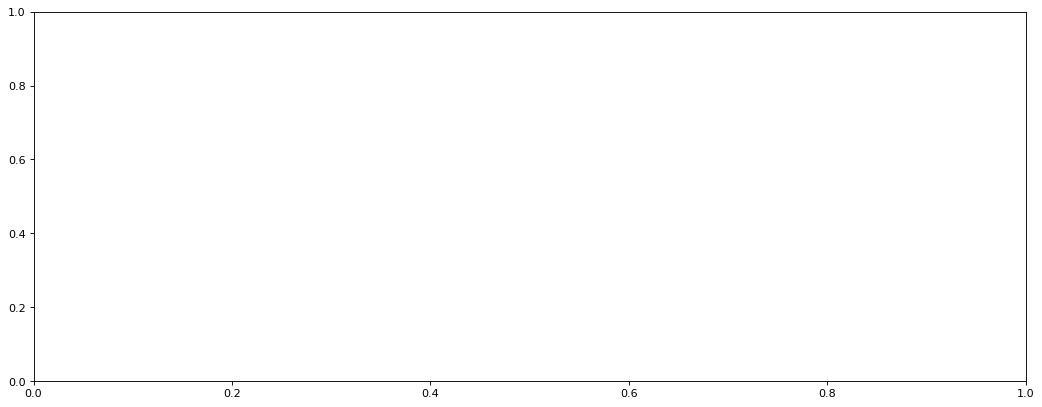

In [ ]:
# rf = grid_search.best_estimator_.fit(X_train_best,y_train)
# result = permutation_importance(rf, X_train_best, y_train, n_repeats=10, random_state=0, n_jobs=-1)

fig, ax = plt.subplots(figsize=(16, 6))
box_plot = ax.boxplot(result.importances.T, vert=False, labels=selected_features)
for median in box_plot['medians']:
    median.set_color('#95bd95')
ax.set_title("Permutation Importance of each feature",fontsize=16)
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

Moreover, the coefficient variability analysis we performed earlier with our baseline model is equivalent to analysing feature importance for our HBGB model. Feature importance is *"a model inspection technique that seeks to measure each feature to a fitted model’s statistical performance on a given tabular dataset"*<sup>9</sup>. Particularly, in this case we choose to execute a permutation feature importance analysis, which is performed on the fit of the model on the test data, helping to identify real factor relevance even in cases in which the model may have better performance in training data<sup>10</sup>.

As shown in the visualisation above, in line with the results of our baseline model, age, education and quality of life are among the most important factors to predict dementia severity. Nonetheless, in our final model we can identify a remarkable significance of an additional feature, which takes the position of the second most relevant predictor for dementia severity: *obesity*.

In [ ]:
model_comparison = {'Model': ['Baseline', 'Polynomial', 'Ridge', 'Elastic Net',
                    'Random Forest','Histogram-Based Gradient Boosting'],
                    'MSE': [baseline_MSE,poly_MSE,ridge_MSE,EN_MSE,RF_MSE,HGB_MSE],
                    'RMSE':[baseline_RMSE,poly_RMSE,ridge_RMSE,EN_RMSE,RF_RMSE,HGB_RMSE],
                    'R-Squared':[baseline_R2,poly_R2,ridge_R2,EN_R2,RF_R2,HGB_R2]}  
model_comparison = pd.DataFrame(model_comparison)  
model_comparison=model_comparison.set_index('Model')
model_comp_df = model_comparison.style.format('{}')
model_comp_df.set_table_styles([index_names, headers])

,MSE,RMSE,R-Squared
Model,,,
Baseline,11.9598,3.4583,0.283
Polynomial,10.6257,3.2597,0.3496
Ridge,10.8157,3.2887,0.3379
Elastic Net,10.8157,3.2887,0.3379
Random Forest,12.8146,3.5797,0.2317
Histogram-Based Gradient Boosting,10.5917,3.2545,0.365


Finally, when comparing all the models evaluated in the present study, it is evident that the histogram-based gradient boosting regression overcomes the rest of the models, with a lower MSE and higher R-Squared. However, it is worth noting that performing grid search on this model is computationally costly. If computational resources are limited, a polynomial model with degree $2$ could be worth exploring, given it is the model with closest performance to the HBGB regression and its computationally more economical. Hence, we have a tradeoff between better predictive accuracy and computational power as one might expect and this is a limitation of the work done in this study.

# Discussion & Conclusions

The motivation of this study was to better understand risk factors for dementia severity in the context of the European Union, detecting pattern and trends that allow for insights into dementia prediction, thus identifying possible areas of focus for policymakers. 

To this objective, this study used the easySHARE data, a simplified dataset resulting from the Survey of Health, Ageing and Retirement in Europe (SHARE) which 28 different countries participate in. After the evaluation of several machine learning models (*Baseline*: linear regression. *Alternatives:* polynomial, ridge, elastic net, random forest and histogram-based gradient boosting regressions), we chose the final predictive model to be the Histogram-Based Gradient Boosting (HBGB) Regression, which minimised the fitting error during cross-validation, hence maximising the model predictive power, compared to the rest of the models. Specifically, the baseline model had an R-squared of $28.2\%$, while the HBGB regression increased this metric to $36.5\%$. 

This moderately low predictive power could be due to the fact that easySHARE mixes different waves of the SHARE survey, and if risk factor effects were to have changed over time, our dataset would not be able to capture this. Additionally, other studies restructured as classification problems that use logistic regressions as a tool to predict a categorical dementia dependen variable may yield more predictive power to assess dementia prevalence. 

It is also important to note that this model is computationally expensive to perform cross-validation to and find its optimal parameters. Moreover, because it is an ensemble model (a model that combines multiple weaker models to obtain better predictive results), there are no coefficients in the model output, which does not allow for straightforward way to do inference on the size/direction of the effect of each of the risk factors. Nonetheless, we chose this model for its superior prediction performance.

The main takeaways from this model can be summed up in the following points:

- Age is the most significant factor when predicting dementia severity, given ageing deteriorates individuals' cognitive abilities. This could suggest that policies targeted to maintain the productivity and engagement of elderly people in society would be beneficial as a prevention mechanism for dementia severity.

- The second most relevant risk factor for dementia severity is obesity. It is important to note that an increasing weight will not necessarily increase the probabilities that an individual gets more severe dementia as long as certain thresholds of weight aren't crossed. Weight begins to be relevant as a risk factor when individuals are overweight or obsese. This points to the fact that policies should be targeted to avoid obesity, which is in line with the fact that physical activity level was also mildly relevant for the model's predictive power.

- Another pertinent factor detected by our model was quality of life. This particular variable reflects people's perception on their control, autonomy, pleasure and self-realization. Although this is quite a general factor and does not necessarily translate to specific public policy recommendations, it is worth noting that it gives policymakers the hope that in working towards a more inclusive society with basic coverage for human rights (health, education, recreation spaces, etc.), they are also working to reduce overall dementia severity.

- Finally, it is significant to address that women tend to have worse dementia severity than males. This distinction must be taken into consideration at the time of policymaking, seeking to ensure that female populations are being adequately targeted by the policies, and contemplating possible extra measure for this segment of the population.

Taking these risk factors into consideration at the time of addressing the needs of society through public policies could change the course of dementia statistics and make way for a better tomorrow. Along with the rest of the available literature, we invite the European Union to take action on dementia and guarantee a better future for the Europeans of today, which inevitably translates in higher life quality for the Europeans of tomorrow.

# References

***Dataset:*** Börsch-Supan, A. & S. Gruber (2022): easySHARE. Release version: 8.0.0. SHARE-ERIC. Dataset. doi: 10.6103/SHARE.easy.800.

<sup>1</sup> "World Population Prospects 2022, Summary of Results", United Nations, accessed February 29, 2024, *https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/wpp2022_summary_of_results.pdf*.

<sup>2</sup> "Ageing and Health", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/fact-sheets/detail/ageing-and-health#:~:text=Every%20country%20in%20the%20world,in%202020%20to%201.4%20billion.*.

<sup>3</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

<sup>4</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

<sup>5</sup> Page 123, Feature Engineering and Selection, 2019, accessed March 5, 2024, *https://shorturl.at/mCKNX*.

<sup>6</sup> "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

<sup>7</sup> "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

<sup>8</sup> "A Faster Ensemble Model Method in Sklearn: Histogram-Based Gradient Boosting", Medium, accessed March 8, 2024, *https://medium.com/chat-gpt-now-writes-all-my-articles/a-faster-ensemble-model-method-in-sklearn-histogram-based-gradient-boosting-7033ff170bc0*.

<sup>9</sup> "Permutation feature importance", Scikit-learn.org, accessed March 9, 2024, *https://scikit-learn.org/stable/modules/permutation_importance.html*.

<sup>10</sup> "Permutation importance vs impurity-based feature importance", Medium, accessed March 9, 2024, *https://medium.com/@syoussefi600/permutation-importance-vs-impurity-based-feature-importance-1c1a8d027479*.

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project1.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 392, in from_file
    return super().from_file(file_stream, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/lib/python3.10/site-packages/